# Latent inference with Acuario: two peaks (variants)
Dictionary-based SIR model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import pyross
import time
import pickle
from scipy import optimize
from scipy.linalg import eig

## Data from Acuario: Omicron

In [2]:
data_acuario = pd.read_csv('I_acuario.csv', index_col=0)
data_acuario_tot = pd.DataFrame(data_acuario.sum(axis=1), columns=['new_cases'])
t = range(0, len(data_acuario_tot))
omicron_start = 627
omicron_end_1st = 670
omicron_end = 710
data_acuario_tot_omicron = data_acuario_tot.iloc[omicron_start:omicron_end]
data_acuario_tot_omicron_1st = data_acuario_tot.iloc[omicron_start:omicron_end_1st]

Text(0.5, 0, 'Days since 2022-04-15')

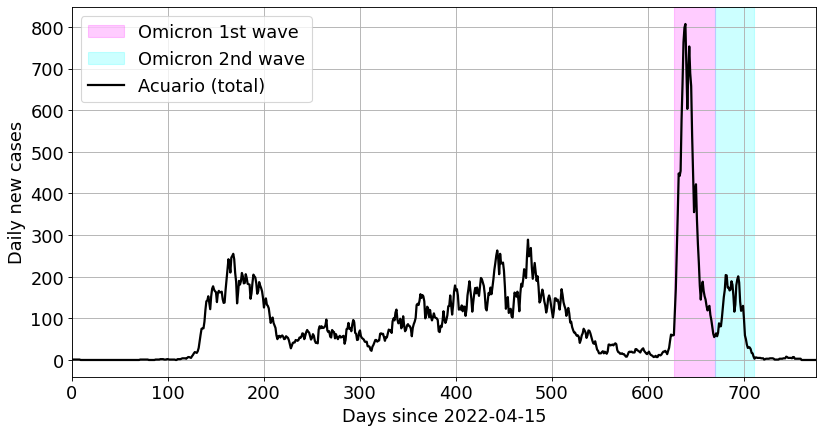

In [3]:
lwidth = 2
fsize = 16

fig1 = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

ax1.axvspan(omicron_start, omicron_end_1st, label='Omicron 1st wave', alpha=0.2, color='magenta')
ax1.axvspan(omicron_end_1st, omicron_end, label='Omicron 2nd wave', alpha=0.2, color='cyan')

ax1.plot(t, data_acuario_tot['new_cases'], 'k-', label='Acuario (total)', lw=lwidth)

ax1.legend()
ax1.grid()
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('Daily new cases')
ax1.set_xlabel('Days since 2022-04-15')


## Model definition

In [4]:
model_spec = {
    "classes" : ["S", "IA", "IB", "IAB", "IBA", "RA", "RB", "R"],

    "S" : {
        "infection" : [ ["IA", "S", "-betaA"],
                        ["IB", "S", "-betaB"],
                        ["IBA", "S", "-betaA"],
                        ["IAB", "S", "-betaB"]],
        "linear" :     [["S", "-new_var_kickB"]], # generate cases from new variant
    },

    "IA" : {
        "linear"    : [ ["IA", "-gamma"]],
        "infection" : [ ["IA", "S", "betaA"],
                        ["IBA", "S", "betaA"]]
    },

    "IB" : {
        "linear"    : [ ["IB", "-gamma"],
                        ["S", "new_var_kickB"]], # generate cases from new variant
        "infection" : [ ["IB", "S", "betaB"],
                        ["IAB", "S", "betaB"]]
    },

    "RA" : { # recovered from IA, suceptible to IB
        "linear"    : [ ["IA", "gamma"]],
        "infection" : [ ["IB", "RA", "-betaB"],
                        ["IAB", "RA", "-betaB"]]
    },
    
    "RB" : { # recovered from IB, suceptible to IA
        "linear"    : [ ["IB", "gamma"]],
        "infection" : [ ["IA", "RB", "-betaA"],
                        ["IBA", "RB", "-betaA"]]
    },
    
    "IAB" : { # infected with A, then B
        "linear"    : [ ["IAB", "-gamma"]],
        "infection" : [ ["IB", "RA", "betaB"],
                        ["IAB", "RA", "betaB"]]
    },

    "IBA" : { # infected with B, then A
        "linear"    : [ ["IBA", "-gamma"]],
        "infection" : [ ["IA", "RB", "betaA"],
                        ["IBA", "RB", "betaA"]]
    },

    "R" : { # recovered from both
        "linear"    : [ ["IAB", "gamma"],
                        ["IBA", "gamma"]]
    }
}

model_spec

{'classes': ['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'],
 'S': {'infection': [['IA', 'S', '-betaA'],
   ['IB', 'S', '-betaB'],
   ['IBA', 'S', '-betaA'],
   ['IAB', 'S', '-betaB']],
  'linear': [['S', '-new_var_kickB']]},
 'IA': {'linear': [['IA', '-gamma']],
  'infection': [['IA', 'S', 'betaA'], ['IBA', 'S', 'betaA']]},
 'IB': {'linear': [['IB', '-gamma'], ['S', 'new_var_kickB']],
  'infection': [['IB', 'S', 'betaB'], ['IAB', 'S', 'betaB']]},
 'RA': {'linear': [['IA', 'gamma']],
  'infection': [['IB', 'RA', '-betaB'], ['IAB', 'RA', '-betaB']]},
 'RB': {'linear': [['IB', 'gamma']],
  'infection': [['IA', 'RB', '-betaA'], ['IBA', 'RB', '-betaA']]},
 'IAB': {'linear': [['IAB', '-gamma']],
  'infection': [['IB', 'RA', 'betaB'], ['IAB', 'RA', 'betaB']]},
 'IBA': {'linear': [['IBA', '-gamma']],
  'infection': [['IA', 'RB', 'betaA'], ['IBA', 'RB', 'betaA']]},
 'R': {'linear': [['IAB', 'gamma'], ['IBA', 'gamma']]}}

Parameter values:

In [5]:
betaA = 0.37
betaB = 0.2
gamma = 0.35
new_var_kickB = 0.2
start_timeB = 40
parameters = {
    'betaA' : betaA,
    'betaB' : betaB,
    'gamma' : gamma,
    'new_var_kickB' : new_var_kickB,
    'start_timeB': start_timeB
}

In [6]:
def parameter_mapping(input_parameters, t):
    output_parameters = {
        'betaA' : input_parameters['betaA'],
        'betaB' : input_parameters['betaB'],
        'gamma' : input_parameters['gamma'],
        'start_timeB' : input_parameters['start_timeB'],
    }
    start_timeB = input_parameters['start_timeB']
    if t>start_timeB and t<start_timeB+1:
        output_parameters['new_var_kickB'] = input_parameters['new_var_kickB']
    else:
        output_parameters['new_var_kickB'] = 0

    return output_parameters

## Synthetic data
Single age group

In [7]:
N_pop = 4000

In [8]:
M = 1
Ni = N_pop*np.ones(M)
N = np.sum(Ni) 

if M==2:
    IA0 = np.array([5.0, 0.0])
    IB0 = np.array([0.0, 0.0])
    IAB0 = np.array([0.0, 0.0])
    IBA0 = np.array([0.0, 0.0])
    RA0 = np.array([0.0, 0.0])
    RB0 = np.array([0.0, 0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0, 0.0])
else:
    IA0 = np.array(data_acuario_tot_omicron.iloc[0])
    IB0 = np.array([0.0])
    IAB0 = np.array([0.0])
    IBA0 = np.array([0.0])
    RA0 = np.array([0.0])
    RB0 = np.array([0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0])

x0 = {
    'S' : S0,
    'IA' : IA0,
    'IB' : IB0,
    'IAB' : IAB0,
    'IBA' : IBA0,
    'RA' : RA0,
    'RB' : RB0,
    'R' : R0
}

# the contact matrix is time-dependent
def contactMatrix(t):
    return np.identity(M)*2

# duration of simulation and data file
Tf = len(data_acuario_tot_omicron) - 1
Nf = Tf + 1

# model instantiation
model = pyross.stochastic.Model(model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

# just in case, save synthetic data
data_array = data['X'].astype('float')
x = data_array

Plot time series

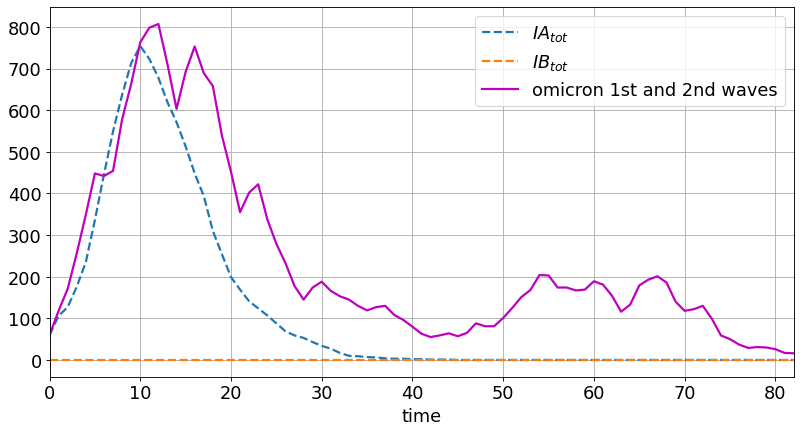

In [9]:
fig1 = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)
t = data['t']

IA = np.sum(model.model_class_data('IA',data), axis=1)
IB = np.sum(model.model_class_data('IB',data), axis=1)
IAB = np.sum(model.model_class_data('IAB',data), axis=1)
IBA = np.sum(model.model_class_data('IBA',data), axis=1)

ax1.plot(t, IA+IBA, '--', label='$IA_{tot}$', lw=lwidth)
ax1.plot(t, IB+IAB, '--', label='$IB_{tot}$', lw=lwidth)

ax1.plot(t, data_acuario_tot_omicron['new_cases'], 'm-', label='omicron 1st and 2nd waves', lw=lwidth)

plt.legend()
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [25]:
Tf_inference_1st = 80
Tf_inference_1st_v1 = 60
Tf_inference_1st_v2 = 55
Tf_inference_1st_v3 = 50

N_runs = 10 # number of runs with fitted parameters

## Inference: fit double peak, no prediction (omicron 1st and 2nd waves)

In [11]:
N_start = 0
Tf_inference = Tf_inference_1st
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3940   60    0    0    0    0    0    0]


In [12]:
# active cases
fltr = np.kron([0, 1, 1, 1, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_tot_omicron.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 1. 1. 1. 1. 0. 0. 0.]]
(81, 8)
(81, 1)


In [13]:
# compute -log_p for the original (correct) parameters 
start_time = time.time()
x0 = x[0]

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp)
print(end_time - start_time)

1695.2282431594276
0.16686058044433594


#### Priors

In [14]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'betaB':{
        'mean': betaB_g,
        'std': 2*betaB_g,
        'bounds': [eps, 4*betaB_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    },
    'start_timeB':{
        'mean': start_timeB_g,
        'std': 0.5*start_timeB_g,
        'bounds': [0.75*start_timeB_g, 1.25*start_timeB_g],
        'prior_fun': 'truncnorm'
    },
    'new_var_kickB':{
        'mean': new_var_kickB_g,
        'std': 0.5*new_var_kickB_g,
        'bounds': [eps, 2*new_var_kickB_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [*Ni*0.99, eps, eps, eps, eps, eps, eps],
        'std': [100, 1, 1, 1, 1, 1, 1],
        'bounds': [[*Ni*0.9, *Ni], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True, False,  True,  True,  True,  True,  True,  True]),
  'mean': [3960.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
  'std': [100, 1, 1, 1, 1, 1, 1],
  'bounds': [[3600.0, 4000.0],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [15]:
# optimisation parameters 
ftol = 1e-11#1e-8 # the relative tol in (-logp)  
global_atol = 0.0001#0.1

global_max_iter = 2000#2000
local_max_iter = 1000#1000
#objective_fun = 'least_squares'
objective_fun = 'likelihood'

estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=4069348679, Wed Oct 19 10:54:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 2.557737509645085e+03 1.0e+00 9.76e-01  1e-01  1e+02 0:00.9
    2     32 4.020975540510215e+03 1.2e+00 9.15e-01  9e-02  9e+01 0:01.7
    3     48 7.099810848677727e+03 1.2e+00 8.72e-01  9e-02  9e+01 0:02.7
    7    112 2.352748634607278e+03 1.5e+00 8.27e-01  9e-02  8e+01 0:06.3
   12    192 1.973284320769782e+03 2.0e+00 7.53e-01  8e-02  8e+01 0:10.5
   19    304 1.277396540514098e+03 2.3e+00 5.37e-01  6e-02  5e+01 0:16.0
   27    432 9.626036056997356e+02 2.5e+00 3.98e-01  4e-02  4e+01 0:23.1
   32    512 6.410359235134785e+02 2.8e+00 3.35e-01  3e-02  3e+01 0:30.5
   38    608 7.912348356953190e+02 3.3e+00 2.41e-01  2e-02  2e+01 0:39.1
   46    736 6.726222136843236e+02 4.9e+00 2.93e-01  3e-02  3e+01 0:48.5
   59    944 6.542823879771738e+02 8.8e+00 2.75e-01  3e-02  3e+01 0:5

In [22]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron = res_omicron['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron = res_omicron['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron, map_x0_omicron, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.2, 'gamma': 0.35, 'new_var_kickB': 0.2, 'start_timeB': 40}

 Best estimates
{'betaA': 0.27110262444467265, 'betaB': 0.19000054607385514, 'gamma': 0.2526111804471082, 'new_var_kickB': 0.23770085252699674, 'start_timeB': 39.665350699781136}

 True initial conditions: 
['-', 60, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3999   59    0    0    0    0    0    0]

 log p for best estimates:
562.4844804244608


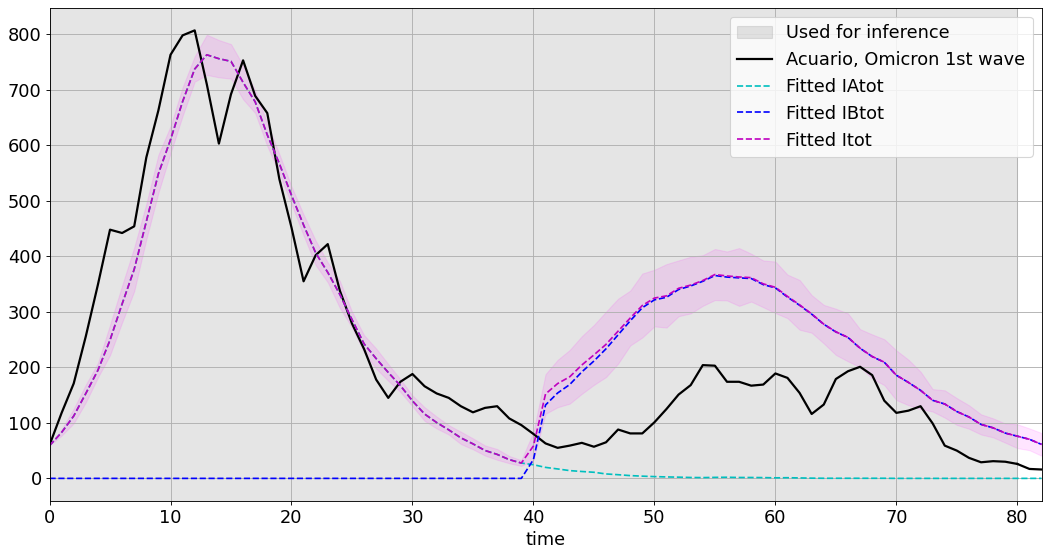

In [23]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_tot_omicron['new_cases'][:N_start+Tf_inference+1], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_tot_omicron['new_cases'][N_start+Tf_inference:], 'k-', lw=lwidth)

# show stochastic variability
N_runs = 5
IA_fit = np.zeros([N_runs,Nf],dtype=float)
IB_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_fit[loop] = np.sum(model_fit.model_class_data('IA',data_fit), axis=1)
    IB_fit[loop] = np.sum(model_fit.model_class_data('IB',data_fit), axis=1)
    IAB_fit[loop] = np.sum(model_fit.model_class_data('IAB',data_fit), axis=1)
    IBA_fit[loop] = np.sum(model_fit.model_class_data('IBA',data_fit), axis=1)

IAtot_fit_omicron_mean = np.mean(IA_fit+IBA_fit,axis=0)
IAtot_fit_omicron_std = np.std(IA_fit+IBA_fit,axis=0)
IBtot_fit_omicron_mean = np.mean(IB_fit+IAB_fit,axis=0)
IBtot_fit_omicron_std = np.std(IB_fit+IAB_fit,axis=0)
Itot_fit_omicron_mean = np.mean(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)
Itot_fit_omicron_std = np.std(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)

plt.plot(t[N_start:Nf+N_start], IAtot_fit_omicron_mean, 'c--',label='Fitted IAtot')
plt.plot(t[N_start:Nf+N_start], IBtot_fit_omicron_mean, 'b--',label='Fitted IBtot')
plt.plot(t[N_start:Nf+N_start], Itot_fit_omicron_mean, 'm--',label='Fitted Itot')
plt.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron_mean-Itot_fit_omicron_std,Itot_fit_omicron_mean+Itot_fit_omicron_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## Inference: fit double peak, with prediction (v1)

In [27]:
N_start = 0
Tf_inference = Tf_inference_1st_v1
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3940   60    0    0    0    0    0    0]


In [28]:
# active cases
fltr = np.kron([0, 1, 1, 1, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_tot_omicron.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 1. 1. 1. 1. 0. 0. 0.]]
(61, 8)
(61, 1)


In [29]:
# compute -log_p for the original (correct) parameters 
start_time = time.time()
x0 = x[0]

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp)
print(end_time - start_time)

1529.9460462136656
0.11421561241149902


#### Priors

In [30]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'betaB':{
        'mean': betaB_g,
        'std': 2*betaB_g,
        'bounds': [eps, 4*betaB_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    },
    'start_timeB':{
        'mean': start_timeB_g,
        'std': 0.5*start_timeB_g,
        'bounds': [0.75*start_timeB_g, 1.25*start_timeB_g],
        'prior_fun': 'truncnorm'
    },
    'new_var_kickB':{
        'mean': new_var_kickB_g,
        'std': 0.5*new_var_kickB_g,
        'bounds': [eps, 2*new_var_kickB_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [*Ni*0.99, eps, eps, eps, eps, eps, eps],
        'std': [100, 1, 1, 1, 1, 1, 1],
        'bounds': [[*Ni*0.9, *Ni], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True, False,  True,  True,  True,  True,  True,  True]),
  'mean': [3960.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
  'std': [100, 1, 1, 1, 1, 1, 1],
  'bounds': [[3600.0, 4000.0],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [31]:
objective_fun = 'least_squares'
#objective_fun = 'likelihood'

estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron_v1 = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=1467886314, Wed Oct 19 11:36:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.057265274123723e+03 1.0e+00 9.33e-01  9e-02  9e+01 0:00.7
    2     32 1.445425503688474e+03 1.1e+00 9.05e-01  9e-02  9e+01 0:01.4
    3     48 8.394147213300121e+02 1.2e+00 9.42e-01  9e-02  9e+01 0:02.2
    8    128 1.150629980320769e+03 1.5e+00 9.75e-01  1e-01  9e+01 0:05.7
   14    224 1.018599711970478e+03 1.9e+00 9.93e-01  1e-01  9e+01 0:09.8
   21    336 9.824362404395232e+02 2.1e+00 1.26e+00  1e-01  1e+02 0:14.8
   30    480 5.396949736691237e+02 3.1e+00 8.94e-01  1e-01  8e+01 0:21.3
   41    656 6.305622236707432e+02 3.5e+00 8.11e-01  9e-02  8e+01 0:28.6
   54    864 6.211769736832644e+02 5.0e+00 6.84e-01  7e-02  6e+01 0:37.2
   69   1104 5.496462076416583e+02 8.7e+00 5.14e-01  6e-02  5e+01 0:46.4
   86   1376 5.332484328544135e+02 1.1e+01 3.06e-01  3e-02  3e+01 0:5

In [32]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron_v1 = res_omicron_v1['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron_v1)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron_v1 = res_omicron_v1['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron_v1.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron_v1, map_x0_omicron_v1, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.2, 'gamma': 0.35, 'new_var_kickB': 0.2, 'start_timeB': 40}

 Best estimates
{'betaA': 0.2653484669114255, 'betaB': 0.18447499258449443, 'gamma': 0.23593532784614202, 'new_var_kickB': 0.23220031020784748, 'start_timeB': 45.333366219898345}

 True initial conditions: 
['-', 60, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3982   58    0    0    0    0    0    0]

 log p for best estimates:
437.25977019210256


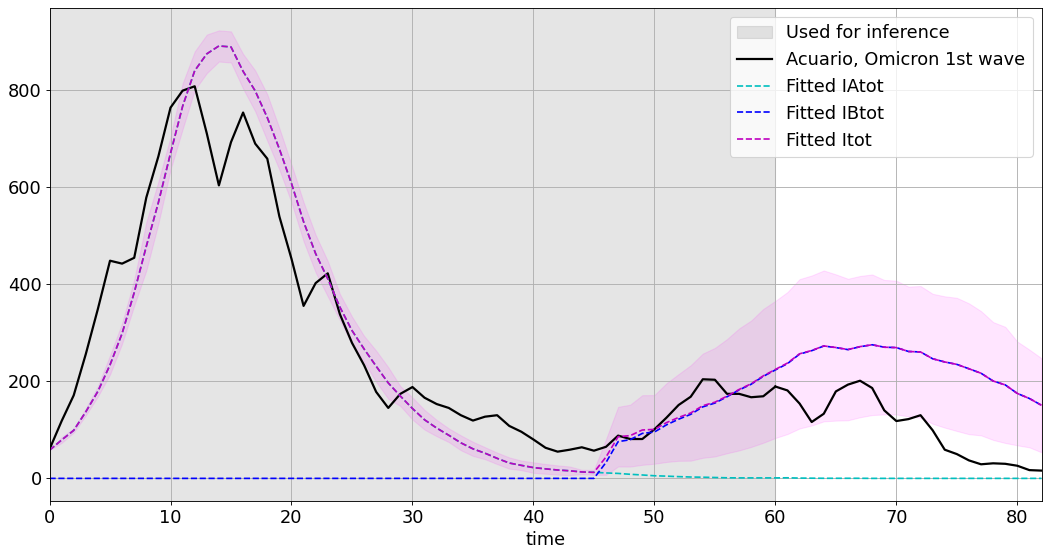

In [33]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron_v1
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_tot_omicron['new_cases'][:N_start+Tf_inference+1], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_tot_omicron['new_cases'][N_start+Tf_inference:], 'k-', lw=lwidth)

# show stochastic variability
N_runs = 5
IA_fit = np.zeros([N_runs,Nf],dtype=float)
IB_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron_v1, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_fit[loop] = np.sum(model_fit.model_class_data('IA',data_fit), axis=1)
    IB_fit[loop] = np.sum(model_fit.model_class_data('IB',data_fit), axis=1)
    IAB_fit[loop] = np.sum(model_fit.model_class_data('IAB',data_fit), axis=1)
    IBA_fit[loop] = np.sum(model_fit.model_class_data('IBA',data_fit), axis=1)

IAtot_fit_omicron_v1_mean = np.mean(IA_fit+IBA_fit,axis=0)
IAtot_fit_omicron_v1_std = np.std(IA_fit+IBA_fit,axis=0)
IBtot_fit_omicron_v1_mean = np.mean(IB_fit+IAB_fit,axis=0)
IBtot_fit_omicron_v1_std = np.std(IB_fit+IAB_fit,axis=0)
Itot_fit_omicron_v1_mean = np.mean(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)
Itot_fit_omicron_v1_std = np.std(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)

plt.plot(t[N_start:Nf+N_start], IAtot_fit_omicron_v1_mean, 'c--',label='Fitted IAtot')
plt.plot(t[N_start:Nf+N_start], IBtot_fit_omicron_v1_mean, 'b--',label='Fitted IBtot')
plt.plot(t[N_start:Nf+N_start], Itot_fit_omicron_v1_mean, 'm--',label='Fitted Itot')
plt.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron_v1_mean-Itot_fit_omicron_v1_std,Itot_fit_omicron_v1_mean+Itot_fit_omicron_v1_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [45]:
with open("acuario_fit_doublepeak.pkl", "wb") as f:
    pickle.dump([{"IAtot_fit_omicron_mean": IAtot_fit_omicron_mean, "IAtot_fit_omicron_std": IAtot_fit_omicron_std,
                "IBtot_fit_omicron_mean": IBtot_fit_omicron_mean, "IBtot_fit_omicron_std": IBtot_fit_omicron_std,
                "Itot_fit_omicron_mean": Itot_fit_omicron_mean, "Itot_fit_omicron_std": Itot_fit_omicron_std,
                "IAtot_fit_omicron_v1_mean": IAtot_fit_omicron_v1_mean, "IAtot_fit_omicron_v1_std": IAtot_fit_omicron_v1_std,
                "IBtot_fit_omicron_v1_mean": IBtot_fit_omicron_v1_mean, "IBtot_fit_omicron_v1_std": IBtot_fit_omicron_v1_std,
                "Itot_fit_omicron_v1_mean": Itot_fit_omicron_v1_mean, "Itot_fit_omicron_v1_std": Itot_fit_omicron_v1_std,
                "IAtot_fit_omicron_v2_mean": IAtot_fit_omicron_v2_mean, "IAtot_fit_omicron_v2_std": IAtot_fit_omicron_v2_std,
                "IBtot_fit_omicron_v2_mean": IBtot_fit_omicron_v2_mean, "IBtot_fit_omicron_v2_std": IBtot_fit_omicron_v2_std,
                "Itot_fit_omicron_v2_mean": Itot_fit_omicron_v2_mean, "Itot_fit_omicron_v2_std": Itot_fit_omicron_v2_std,
                "data_acuario_tot_omicron": data_acuario_tot_omicron,
                 "best_estimates_omicron": best_estimates_omicron,
                 "best_estimates_omicron_v1": best_estimates_omicron_v1,
                 "best_estimates_omicron_v2": best_estimates_omicron_v2}], f)

## Inference: fit double peak, with prediction (v2)

In [35]:
N_start = 0
Tf_inference = Tf_inference_1st_v2
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3940   60    0    0    0    0    0    0]


In [36]:
# active cases
fltr = np.kron([0, 1, 1, 1, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_tot_omicron.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 1. 1. 1. 1. 0. 0. 0.]]
(56, 8)
(56, 1)


In [37]:
# compute -log_p for the original (correct) parameters 
start_time = time.time()
x0 = x[0]

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp)
print(end_time - start_time)

1505.0450305114703
0.11258530616760254


#### Priors

In [38]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'betaB':{
        'mean': betaB_g,
        'std': 2*betaB_g,
        'bounds': [eps, 4*betaB_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    },
    'start_timeB':{
        'mean': start_timeB_g,
        'std': 0.5*start_timeB_g,
        'bounds': [0.75*start_timeB_g, 1.25*start_timeB_g],
        'prior_fun': 'truncnorm'
    },
    'new_var_kickB':{
        'mean': new_var_kickB_g,
        'std': 0.5*new_var_kickB_g,
        'bounds': [eps, 2*new_var_kickB_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [*Ni*0.99, eps, eps, eps, eps, eps, eps],
        'std': [100, 1, 1, 1, 1, 1, 1],
        'bounds': [[*Ni*0.9, *Ni], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True, False,  True,  True,  True,  True,  True,  True]),
  'mean': [3960.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
  'std': [100, 1, 1, 1, 1, 1, 1],
  'bounds': [[3600.0, 4000.0],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [39]:
objective_fun = 'likelihood'

estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron_v2 = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=2786111435, Wed Oct 19 12:06:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.925699705431076e+02 1.0e+00 9.62e-01  9e-02  1e+02 0:00.6
    2     32 9.928941085993310e+02 1.2e+00 8.45e-01  8e-02  8e+01 0:01.3
    3     48 7.526211269198284e+02 1.2e+00 8.36e-01  8e-02  8e+01 0:02.0
    8    128 6.242045895195378e+02 1.5e+00 8.30e-01  8e-02  8e+01 0:05.2
   15    240 1.084027340779031e+03 1.8e+00 9.70e-01  1e-01  9e+01 0:09.4
   24    384 2.087982527936519e+03 2.5e+00 1.14e+00  1e-01  1e+02 0:15.0
   34    544 5.519168628523551e+02 3.0e+00 9.52e-01  9e-02  9e+01 0:21.2
   46    736 5.116208484733176e+02 3.7e+00 6.16e-01  5e-02  6e+01 0:28.4
   60    960 5.159226856644924e+02 5.1e+00 3.08e-01  2e-02  3e+01 0:36.5
   76   1216 4.844043719158460e+02 8.4e+00 1.66e-01  1e-02  1e+01 0:45.7
   91   1456 4.761927460325312e+02 1.4e+01 1.18e-01  9e-03  1e+01 0:5

In [40]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron_v2 = res_omicron_v2['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron_v2)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron_v2 = res_omicron_v2['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron_v2.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron_v2, map_x0_omicron_v2, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.2, 'gamma': 0.35, 'new_var_kickB': 0.2, 'start_timeB': 40}

 Best estimates
{'betaA': 0.2679567683847274, 'betaB': 0.19343052009354775, 'gamma': 0.23746155755346593, 'new_var_kickB': 0.058311493929934816, 'start_timeB': 49.35914315693639}

 True initial conditions: 
['-', 60, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3999   58    0    0    0    0    0    0]

 log p for best estimates:
412.1283966302218


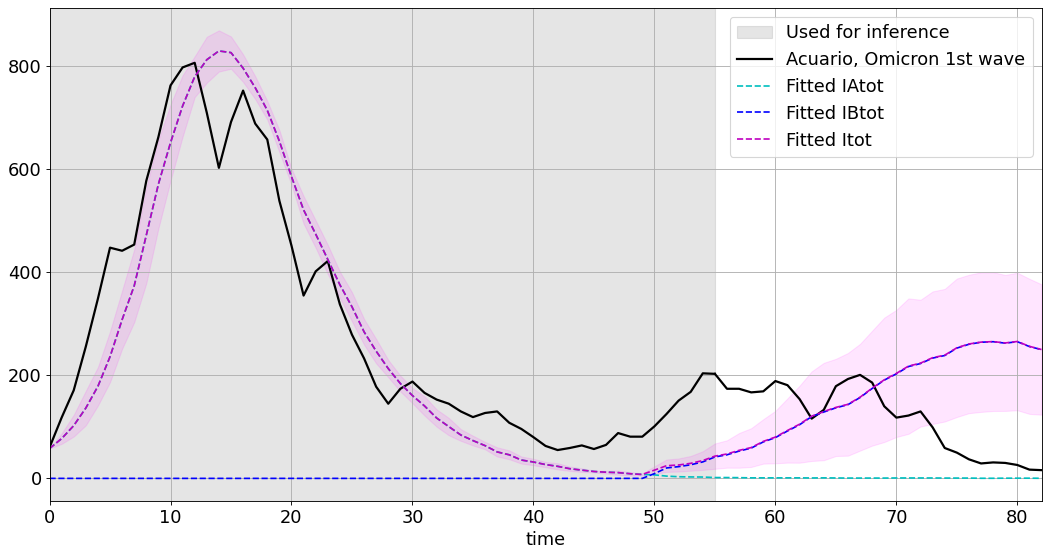

In [41]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron_v2
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_tot_omicron['new_cases'][:N_start+Tf_inference+1], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_tot_omicron['new_cases'][N_start+Tf_inference:], 'k-', lw=lwidth)

# show stochastic variability
N_runs = 5
IA_fit = np.zeros([N_runs,Nf],dtype=float)
IB_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron_v2, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_fit[loop] = np.sum(model_fit.model_class_data('IA',data_fit), axis=1)
    IB_fit[loop] = np.sum(model_fit.model_class_data('IB',data_fit), axis=1)
    IAB_fit[loop] = np.sum(model_fit.model_class_data('IAB',data_fit), axis=1)
    IBA_fit[loop] = np.sum(model_fit.model_class_data('IBA',data_fit), axis=1)

IAtot_fit_omicron_v2_mean = np.mean(IA_fit+IBA_fit,axis=0)
IAtot_fit_omicron_v2_std = np.std(IA_fit+IBA_fit,axis=0)
IBtot_fit_omicron_v2_mean = np.mean(IB_fit+IAB_fit,axis=0)
IBtot_fit_omicron_v2_std = np.std(IB_fit+IAB_fit,axis=0)
Itot_fit_omicron_v2_mean = np.mean(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)
Itot_fit_omicron_v2_std = np.std(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)

plt.plot(t[N_start:Nf+N_start], IAtot_fit_omicron_v2_mean, 'c--',label='Fitted IAtot')
plt.plot(t[N_start:Nf+N_start], IBtot_fit_omicron_v2_mean, 'b--',label='Fitted IBtot')
plt.plot(t[N_start:Nf+N_start], Itot_fit_omicron_v2_mean, 'm--',label='Fitted Itot')
plt.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron_v2_mean-Itot_fit_omicron_v2_std,Itot_fit_omicron_v2_mean+Itot_fit_omicron_v2_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [93]:
with open('acuario_ft_doublepeak.pkl', 'rb') as file:
    myvar = pickle.load(file)
  

### Compare among fittings

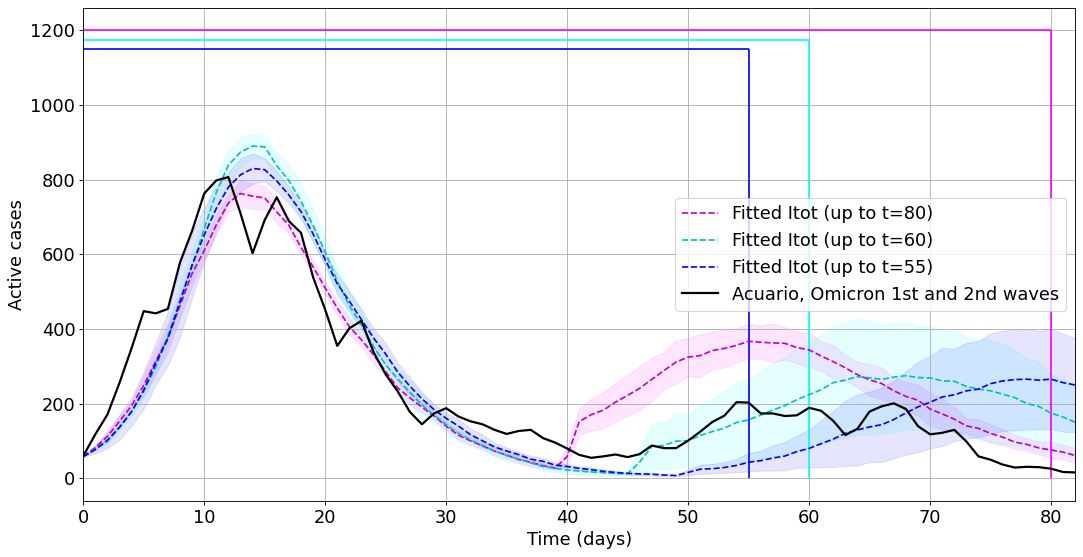

In [44]:
limit_1st = 1200
limit_1st_v1 = 1175
limit_1st_v2 = 1150
limit_1st_v3 = 1125

fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

t = data['t']

ax1.vlines(Tf_inference_1st, 0, limit_1st, colors='magenta', linestyles='-')
ax1.vlines(Tf_inference_1st_v1, 0, limit_1st_v1, colors='cyan', linestyles='-')
ax1.vlines(Tf_inference_1st_v2, 0, limit_1st_v2, colors='blue', linestyles='-')
#ax1.vlines(Tf_inference_1st_v3, 0, limit_1st_v3, colors='green', linestyles='-')
ax1.hlines(limit_1st, 0, Tf_inference_1st, colors='magenta', linestyles='-')
ax1.hlines(limit_1st_v1, 0, Tf_inference_1st_v1, colors='cyan', linestyles='-')
ax1.hlines(limit_1st_v2, 0, Tf_inference_1st_v2, colors='blue', linestyles='-')
#ax1.hlines(limit_1st_v3, 0, Tf_inference_1st_v3, colors='green', linestyles='-')

ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron_mean, 'm--',label='Fitted Itot (up to t=' + str(Tf_inference_1st) + ')')
ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron_mean-Itot_fit_omicron_std,Itot_fit_omicron_mean+Itot_fit_omicron_std,color='magenta', alpha=0.1)

ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron_v1_mean, 'c--',label='Fitted Itot (up to t=' + str(Tf_inference_1st_v1) + ')')
ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron_v1_mean-Itot_fit_omicron_v1_std,Itot_fit_omicron_v1_mean+Itot_fit_omicron_v1_std,color='cyan', alpha=0.1)

ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron_v2_mean, 'b--',label='Fitted Itot (up to t=' + str(Tf_inference_1st_v2) + ')')
ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron_v2_mean-Itot_fit_omicron_v2_std,Itot_fit_omicron_v2_mean+Itot_fit_omicron_v2_std,color='blue', alpha=0.1)

#ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_v3_mean, 'g--',label='Fitted Itot (up to t=' + str(Tf_inference_1st_v3) + ')')
#ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_v3_mean-Itot_fit_omicron1st_v3_std,Itot_fit_omicron1st_v3_mean+Itot_fit_omicron1st_v3_std,color='green', alpha=0.1)


ax1.plot(t, data_acuario_tot_omicron['new_cases'], 'k-', label='Acuario, Omicron 1st and 2nd waves', lw=lwidth)


plt.legend(fontsize=16, loc='right')
plt.grid() 
plt.xlabel(r'Time (days)') 
plt.ylabel(r'Active cases') 
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('acuario_fit_doublepeak.pdf')
plt.savefig('acuario_fit_doublepeak.png', dpi=72)